# CEMS ramp rates by subcomponent

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ramprate.load_dataset import load_epacems, load_epa_crosswalk
import ramprate.build_features as feat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.options.display.max_columns = 50
pd.options.display.max_rows = 75

## Load Datsets

### CEMS

In [4]:
# all states, 1 year
cols = ['plant_id_eia', 'unitid', 'operating_datetime_utc',
        'operating_time_hours', 'gross_load_mw', 'steam_load_1000_lbs',
        'heat_content_mmbtu', 'unit_id_epa',
       ]
cems = load_epacems(states=None, years=[2019], columns=cols, engine='pandas')

In [5]:
%%time
idx = pd.IndexSlice
cems.set_index(['unit_id_epa', 'operating_datetime_utc'], drop=False, inplace=True)#, verify_integrity=True)
cems.sort_index(inplace=True)

CPU times: user 12 s, sys: 3.08 s, total: 15.1 s
Wall time: 15.1 s


### EPA Crosswalk

In [6]:
raw_crosswalk = load_epa_crosswalk()

## Pre-Process

### CEMS

Calculate distance from downtime

In [7]:
feat.calc_distance_from_downtime(cems) # in place

### Cross filter CEMS and crosswalk

#### Make key mapping

In [8]:
key_map = cems.groupby(level='unit_id_epa')[['plant_id_eia', 'unitid', 'unit_id_epa']].first()

In [9]:
key_map

,plant_id_eia,unitid,unit_id_epa
unit_id_epa,,,
1,3,1,1
2,3,2,2
4,3,4,4
5,3,5,5
6,3,6A,6
...,...,...,...
91300,880109,B001,91300
91311,60589,CT-2,91311
91318,880076,430B24,91318


In [10]:
key_map[['plant_id_eia', 'unitid']].duplicated().sum()

0

#### Drop irrelevant crosswalk rows
* no EIA match in crosswalk, which breaks subcomponent finder. (CAMD generators can be substituted if desired. Good enough for fuel types, but not tech type)
* non-exporting industrial facility (EPA manual exclusion)

In [11]:
xwalk = feat._remove_irrelevant(raw_crosswalk)

#### Identify which ID to join on: EIA or CAMD?

In [12]:
key_map.merge(xwalk[['CAMD_PLANT_ID', 'CAMD_UNIT_ID']], left_on=['plant_id_eia', 'unitid'], right_on=['CAMD_PLANT_ID', 'CAMD_UNIT_ID'], how='inner').shape

(5366, 5)

In [13]:
key_map.merge(xwalk[['EIA_PLANT_ID', 'CAMD_UNIT_ID']].astype({'EIA_PLANT_ID': pd.Int32Dtype()}), left_on=['plant_id_eia', 'unitid'], right_on=['EIA_PLANT_ID', 'CAMD_UNIT_ID'], how='inner').shape

(5267, 5)

The merge with CAMD IDs has more records, which makes sense because both are EPA datasets.

#### Apply

In [14]:
key_map = (key_map
           .merge(xwalk,
                  left_on=['plant_id_eia', 'unitid'],
                  right_on=['CAMD_PLANT_ID', 'CAMD_UNIT_ID'],
                  how='inner'
                 )
           )

In [15]:
key_map.shape

(5366, 36)

## Find Subcomponents

In [16]:
key_map = feat.make_subcomponent_ids(key_map, cems)

### Join component IDs to CEMS data

In [ ]:
# how='inner' drops unmatched units. Analyze later.
cems = cems.join(key_map.groupby('unit_id_epa')['component_id'].first(), how='inner')

In [18]:
cems.columns

Index(['plant_id_eia', 'unitid', 'operating_datetime_utc',
       'operating_time_hours', 'gross_load_mw', 'steam_load_1000_lbs',
       'heat_content_mmbtu', 'unit_id_epa', 'hours_from_startup',
       'hours_to_shutdown', 'hours_distance', 'component_id'],
      dtype='object')

#### test for duplicate gross load between units
I should have done this earlier but just remembered it

In [19]:
dupe_load = (cems.loc[cems['gross_load_mw'].gt(0)]
             .duplicated(subset=['plant_id_eia', 'gross_load_mw', 'operating_datetime_utc'], keep=False)
             .groupby('unit_id_epa')
             .agg(['count', 'mean'])
            )

In [20]:
dupe_load.shape

(3712, 2)

In [21]:
dupe_load['mean'].eq(1).agg(['sum', 'mean'])

sum     67.00000
mean     0.01805
Name: mean, dtype: float64

In [22]:
dupe_load.loc[dupe_load['mean'].eq(1), 'count']

unit_id_epa
357        29
358        29
360        22
361        22
363        17
364        17
365        17
366        17
1729      564
1730      564
1731      466
1732      466
1733     1044
1734     1044
1735      697
1736      697
3403       53
3404       33
3405       33
3406       80
3407       80
3409       78
3410       56
3411       56
3412       69
3413       69
3414       97
3415       97
3416      117
3417      117
3418       78
3419       78
3420       70
3421       70
3498       66
3499       90
3500      127
3501       86
3502       37
3503       80
3504       39
3505      132
3506      116
3507       93
3508       77
3509       61
4250      617
4255      531
10215      66
10217      90
10219     127
10221      86
10223      37
10225      80
10227      39
10229     132
10231     116
10233      93
10235      77
10237      61
89913       1
89914       1
90250     134
90457    4267
90458    4267
90461    2536
90462    2536
Name: count, dtype: int64

In [23]:
key_map.groupby('unit_id_epa').first().loc[dupe_load[dupe_load['mean'].eq(1)].index, :]

,component_id,plant_id_eia,unitid,SEQUENCE_NUMBER,CAMD_STATE,CAMD_FACILITY_NAME,CAMD_PLANT_ID,CAMD_UNIT_ID,CAMD_GENERATOR_ID,CAMD_NAMEPLATE_CAPACITY,CAMD_FUEL_TYPE,CAMD_LATITUDE,CAMD_LONGITUDE,CAMD_STATUS,CAMD_STATUS_DATE,CAMD_RETIRE_YEAR,MOD_CAMD_UNIT_ID,MOD_CAMD_GENERATOR_ID,EIA_STATE,EIA_PLANT_NAME,EIA_PLANT_ID,EIA_GENERATOR_ID,EIA_NAMEPLATE_CAPACITY,EIA_BOILER_ID,EIA_UNIT_TYPE,EIA_FUEL_TYPE,EIA_LATITUDE,EIA_LONGITUDE,EIA_RETIRE_YEAR,PLANT_ID_CHANGE_FLAG,MOD_EIA_PLANT_ID,MOD_EIA_BOILER_ID,MOD_EIA_GENERATOR_ID_BOILER,MOD_EIA_GENERATOR_ID_GEN,MATCH_TYPE_GEN,MATCH_TYPE_BOILER
unit_id_epa,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
357,132,563,11A,315.0,CT,South Meadow Station,563,11A,11,41.9,Diesel Oil,41.7495,-72.6524,OPR,1970-08-01T00:00:00,0,11A,11,CT,South Meadow,563.0,11,41.8,None,GT,KER,41.749500,-72.652400,0.0,0.0,563.0,None,None,11,3_1_Generator (generators) match on plant and ...,None
358,132,563,11B,316.0,CT,South Meadow Station,563,11B,11,41.9,Diesel Oil,41.7495,-72.6524,OPR,1970-08-01T00:00:00,0,11B,11,CT,South Meadow,563.0,11,41.8,None,GT,KER,41.749500,-72.652400,0.0,0.0,563.0,None,None,11,3_1_Generator (generators) match on plant and ...,None
360,133,563,12A,317.0,CT,South Meadow Station,563,12A,12,41.9,Diesel Oil,41.7495,-72.6524,OPR,1970-08-01T00:00:00,0,12A,12,CT,South Meadow,563.0,12,41.8,None,GT,KER,41.749500,-72.652400,0.0,0.0,563.0,None,None,12,3_1_Generator (generators) match on plant and ...,None
361,133,563,12B,318.0,CT,South Meadow Station,563,12B,12,41.9,Diesel Oil,41.7495,-72.6524,OPR,1970-08-01T00:00:00,0,12B,12,CT,South Meadow,563.0,12,41.8,None,GT,KER,41.749500,-72.652400,0.0,0.0,563.0,None,None,12,3_1_Generator (generators) match on plant and ...,None
363,134,563,13A,319.0,CT,South Meadow Station,563,13A,13,41.9,Diesel Oil,41.7495,-72.6524,OPR,1970-08-01T00:00:00,0,13A,13,CT,South Meadow,563.0,13,41.8,None,GT,KER,41.749500,-72.652400,0.0,0.0,563.0,None,None,13,3_1_Generator (generators) match on plant and ...,None
364,134,563,13B,320.0,CT,South Meadow Station,563,13B,13,41.9,Diesel Oil,41.7495,-72.6524,OPR,1970-08-01T00:00:00,0,13B,13,CT,South Meadow,563.0,13,41.8,None,GT,KER,41.749500,-72.652400,0.0,0.0,563.0,None,None,13,3_1_Generator (generators) match on plant and ...,None
365,135,563,14A,321.0,CT,South Meadow Station,563,14A,14,41.9,Diesel Oil,41.7495,-72.6524,OPR,1970-08-01T00:00:00,0,14A,14,CT,South Meadow,563.0,14,41.8,None,GT,KER,41.749500,-72.652400,0.0,0.0,563.0,None,None,14,3_1_Generator (generators) match on plant and ...,None
366,135,563,14B,322.0,CT,South Meadow Station,563,14B,14,41.9,Diesel Oil,41.7495,-72.6524,OPR,1970-08-01T00:00:00,0,14B,14,CT,South Meadow,563.0,14,41.8,None,GT,KER,41.749500,-72.652400,0.0,0.0,563.0,None,None,14,3_1_Generator (generators) match on plant and ...,None
1729,658,2511,U00012,1744.0,NY,E F Barrett,2511,U00012,9,41.9,Pipeline Natural Gas,40.6169,-73.6486,OPR,1970-07-01T00:00:00,0,U00012,9,NY,E F Barrett,2511.0,9,41.8,None,GT,NG,40.616689,-73.647881,0.0,0.0,2511.0,None,None,9,3_1_Generator (generators) match on plant and ...,None


The duplicates look to be
* almost all in pairs (won't effect ramp factor)
* almost all GTs (ramp rates not resolvable anyway)
* almost all with very low utilization
* only at a handful of distinct plants

I'll ignore them for now

## Aggregate to subcomponents

### Aggregate metadata

In [24]:
meta = feat.aggregate_subcomponents(key_map)

### Operational aggregates

#### First join in unit types

In [25]:
cems = cems.merge(meta['simple_EIA_UNIT_TYPE'], left_on='component_id', right_index=True, copy=False)
cems.sort_index(inplace=True)

#### Flag the startup/shutdown exclusions by type

In [26]:
cems.dropna(subset=['component_id'])['simple_EIA_UNIT_TYPE'].unique()

['steam_turbine', 'combined_cycle', 'gas_turbine', 'internal_combustion']
Categories (4, object): ['steam_turbine', 'combined_cycle', 'gas_turbine', 'internal_combustion']

In [27]:
thresh_map = {'steam_turbine': 5,
              'combined_cycle': 7,
              'gas_turbine': -1, # no exclusions
              'internal_combustion': -1, # no exclusions
             }

In [28]:
cems['exclude_ramp'] = cems['hours_distance'] <= cems['simple_EIA_UNIT_TYPE'].map(thresh_map)

#### Aggregate load and steam

In [29]:
component_timeseries = (cems.drop(columns=['operating_datetime_utc']) # resolve name collision with index
                        .groupby(['component_id', 'operating_datetime_utc'])[['gross_load_mw', 'steam_load_1000_lbs', 'exclude_ramp']]
                        .sum()
                       )

In [30]:
# sum() > 0 is like combining with logical 'or'
component_timeseries['exclude_ramp'] = component_timeseries['exclude_ramp'] > 0

#### calculate max capacity: sum of maxes and max of sums

In [31]:
component_aggs = (cems.drop(columns=['unit_id_epa']) # resolve name collision with index
                  .groupby(['component_id', 'unit_id_epa'])[['gross_load_mw', 'steam_load_1000_lbs']]
                  .max()
                  .groupby('component_id')
                  .sum()
                  .add_prefix('sum_of_max_')
                 )

In [32]:
component_aggs = component_aggs.join(component_timeseries[['gross_load_mw', 'steam_load_1000_lbs']]
                                    .groupby('component_id')
                                    .max()
                                    .add_prefix('max_of_sum_'),
                                    how='outer' # shouldn't matter
                                   )

In [33]:
# components with both electrical and steam
component_aggs[component_aggs[['sum_of_max_gross_load_mw', 'sum_of_max_steam_load_1000_lbs']].gt(0).all(axis=1)]

,sum_of_max_gross_load_mw,sum_of_max_steam_load_1000_lbs,max_of_sum_gross_load_mw,max_of_sum_steam_load_1000_lbs
component_id,,,,
389,311.0,284.0,311.0,151.0
726,1.0,351.0,1.0,351.0
1577,127.0,597.0,127.0,597.0
2064,189.0,1929.0,189.0,1917.0
2527,34.0,188.0,34.0,188.0
2557,1247.0,912.0,1223.0,615.0
2571,408.0,1189.0,407.0,882.0
3034,25.0,113.0,25.0,113.0
3231,187.0,559.0,187.0,557.0


<AxesSubplot:>

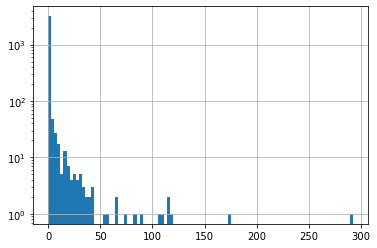

In [34]:
(component_aggs['sum_of_max_gross_load_mw'] - component_aggs['max_of_sum_gross_load_mw']).hist(bins=100, log=True)

In [35]:
# what fraction are equivalent? Recall that 75% of components have only a single unit, so at least 75% should be the same
(component_aggs['sum_of_max_gross_load_mw'] - component_aggs['max_of_sum_gross_load_mw']).eq(0).mean()

0.9205158968206358

**Other options: min, max, count, mean, sum? Utilization? Capacity Factor? Total Energy?**

#### Calculate Ramp Rates
Diff aggregate load, filter by flagged exclusions, take max

In [36]:
component_timeseries[['ramp', 'ramp_steam']] = (component_timeseries
                                                .groupby('component_id')[['gross_load_mw', 'steam_load_1000_lbs']]
                                                .diff()
                                                )

In [37]:
component_timeseries.sample(3)

,,gross_load_mw,steam_load_1000_lbs,exclude_ramp,ramp,ramp_steam
component_id,operating_datetime_utc,,,,,
1360,2019-04-05 04:00:00+00:00,0.0,0.0,False,0.0,0.0
1431,2019-09-27 14:00:00+00:00,0.0,0.0,False,0.0,0.0
2911,2019-01-21 17:00:00+00:00,186.0,0.0,False,1.0,0.0


In [38]:
ramps = (component_timeseries.loc[~component_timeseries['exclude_ramp'], ['ramp', 'ramp_steam']]
         .groupby('component_id')
         .agg(['max', 'min', lambda x: x.idxmax()[1], lambda x: x.idxmin()[1]])
         ).rename(columns={'<lambda_0>': 'idxmax', '<lambda_1>': 'idxmin'}, level=1)

In [39]:
for header in ramps.columns.levels[0]:
    # calculate max abs
    ramps.loc[:, (header, 'max_abs')] = ramps.loc[:, idx[header, ['max', 'min']]].abs().max(axis=1)
    # associate correct timestamp - note that ties go to idxmax, nans go to idxmin
    condition = ramps.loc[:, (header, 'max')] >= ramps.loc[:, (header, 'min')].abs()
    ramps.loc[:, (header, 'idxmax_abs')] = ramps.loc[:, idx[header, 'idxmax']]
    ramps.loc[:, (header, 'idxmax_abs')].where(condition, ramps.loc[:, (header, 'idxmin')], inplace=True)

In [40]:
ramps.sample(5).sort_index(axis=1)

ramp                            \
                                idxmax                idxmax_abs   
component_id                                                       
2081         2019-06-11 02:00:00+00:00 2019-06-11 02:00:00+00:00   
3109         2019-04-12 02:00:00+00:00 2019-12-02 15:00:00+00:00   
2579         2019-05-14 12:00:00+00:00 2019-05-02 04:00:00+00:00   
2982         2019-03-25 17:00:00+00:00 2019-09-11 23:00:00+00:00   
2274         2019-01-01 07:00:00+00:00 2019-01-01 07:00:00+00:00   

                                                            \
                                idxmin   max max_abs   min   
component_id                                                 
2081         2019-05-14 18:00:00+00:00  46.0    46.0 -45.0   
3109         2019-12-02 15:00:00+00:00  40.0    51.0 -51.0   
2579         2019-05-02 04:00:00+00:00  37.0    38.0 -38.0   
2982         2019-09-11 23:00:00+00:00  45.0    51.0 -51.0   
2274         2019-01-01 07:00:00+00:00   0.0     0.0   0.0   

                            ramp_steam                            \
                                idxmax                idxmax_abs   
component_id                                                       
2081         2019-01-01 09:00:00+00:00 2019-01-01 09:00:00+00:00   
3109         2019-01-01 07:00:00+00:00 2019-01-01 07:00:00+00:00   
2579         2019-01-01 07:00:00+00:00 2019-01-01 07:00:00+00:00   
2982         2019-01-01 09:00:00+00:00 2019-01-01 09:00:00+00:00   
2274         2019-01-01 07:00:00+00:00 2019-01-01 07:00:00+00:00   

                                                          
                                idxmin  max max_abs  min  
component_id                                              
2081         2019-01-01 09:00:00+00:00  0.0     0.0  0.0  
3109         2019-01-01 07:00:00+00:00  0.0     0.0  0.0  
2579         2019-01-01 07:00:00+00:00  0.0     0.0  0.0  
2982         2019-01-01 09:00:00+00:00  0.0     0.0  0.0  
2274         2019-01-01 07:00:00+00:00  0.0     0.0  0.0

In [41]:
ramps.columns = ['_'.join(reversed(col)) for col in ramps.columns]

In [42]:
ramps.sample(3)

,max_ramp,min_ramp,idxmax_ramp,idxmin_ramp,max_ramp_steam,min_ramp_steam,idxmax_ramp_steam,idxmin_ramp_steam,max_abs_ramp,idxmax_abs_ramp,max_abs_ramp_steam,idxmax_abs_ramp_steam
component_id,,,,,,,,,,,,
2233,71.0,-67.0,2019-10-01 11:00:00+00:00,2019-09-04 03:00:00+00:00,0.0,0.0,2019-01-01 06:00:00+00:00,2019-01-01 06:00:00+00:00,71.0,2019-10-01 11:00:00+00:00,0.0,2019-01-01 06:00:00+00:00
2274,0.0,0.0,2019-01-01 07:00:00+00:00,2019-01-01 07:00:00+00:00,0.0,0.0,2019-01-01 07:00:00+00:00,2019-01-01 07:00:00+00:00,0.0,2019-01-01 07:00:00+00:00,0.0,2019-01-01 07:00:00+00:00
2972,100.0,-91.0,2019-08-20 11:00:00+00:00,2019-08-16 04:00:00+00:00,0.0,0.0,2019-01-01 07:00:00+00:00,2019-01-01 07:00:00+00:00,100.0,2019-08-20 11:00:00+00:00,0.0,2019-01-01 07:00:00+00:00


### Join it all together

In [43]:
ramps.shape, component_aggs.shape, meta.shape

((3334, 12), (3334, 4), (3334, 6))

In [44]:
component_aggs = component_aggs.join([ramps, meta])

### Normalize ramp rates by capacity(s)

In [45]:
normed = component_aggs[['max_abs_ramp']*4].div(component_aggs[['capacity_CAMD', 'capacity_EIA', 'sum_of_max_gross_load_mw', 'max_of_sum_gross_load_mw']].to_numpy())
normed.columns = ['ramp_factor_' + suf for suf in ['CAMD', 'EIA', 'sum_max', 'max_sum']]
normed

,ramp_factor_CAMD,ramp_factor_EIA,ramp_factor_sum_max,ramp_factor_max_sum
component_id,,,,
0,0.352711,0.352711,0.620690,0.620690
1,0.483344,0.483344,0.880952,0.880952
2,0.448242,0.448353,0.473822,0.473822
3,0.313134,0.313134,0.315051,0.315051
4,0.574744,0.388495,0.335484,0.352542
...,...,...,...,...
3329,0.833333,0.869565,0.869565,0.869565
3330,NaN,0.000000,NaN,NaN
3331,NaN,0.585774,0.823529,0.823529


In [46]:
component_aggs = component_aggs.join(normed)

In [47]:
component_aggs.sample(5)

,sum_of_max_gross_load_mw,sum_of_max_steam_load_1000_lbs,max_of_sum_gross_load_mw,max_of_sum_steam_load_1000_lbs,max_ramp,min_ramp,idxmax_ramp,idxmin_ramp,max_ramp_steam,min_ramp_steam,idxmax_ramp_steam,idxmin_ramp_steam,max_abs_ramp,idxmax_abs_ramp,max_abs_ramp_steam,idxmax_abs_ramp_steam,EIA_UNIT_TYPE,capacity_CAMD,capacity_EIA,simple_CAMD_FUEL_TYPE_via_capacity,simple_EIA_FUEL_TYPE_via_capacity,simple_EIA_UNIT_TYPE,ramp_factor_CAMD,ramp_factor_EIA,ramp_factor_sum_max,ramp_factor_max_sum
component_id,,,,,,,,,,,,,,,,,,,,,,,,,,
516,34.0,0.0,34.0,0.0,30.0,-34.0,2019-09-23 21:00:00+00:00,2019-02-12 21:00:00+00:00,0.0,0.0,2019-01-01 06:00:00+00:00,2019-01-01 06:00:00+00:00,34.0,2019-02-12 21:00:00+00:00,0.0,2019-01-01 06:00:00+00:00,(GT),41.9,41.9,gas,gas,gas_turbine,0.811456,0.811456,1.000000,1.000000
67,0.0,764.0,0.0,764.0,0.0,0.0,2019-01-01 07:00:00+00:00,2019-01-01 07:00:00+00:00,309.0,-344.0,2019-10-01 19:00:00+00:00,2019-09-04 18:00:00+00:00,0.0,2019-01-01 07:00:00+00:00,344.0,2019-09-04 18:00:00+00:00,(ST),136.0,136.0,gas,gas,steam_turbine,0.000000,0.000000,NaN,NaN
2282,60.0,0.0,60.0,0.0,48.0,-42.0,2019-02-07 13:00:00+00:00,2019-11-02 19:00:00+00:00,0.0,0.0,2019-01-01 07:00:00+00:00,2019-01-01 07:00:00+00:00,48.0,2019-02-07 13:00:00+00:00,0.0,2019-01-01 07:00:00+00:00,(GT),121.0,60.5,gas,gas,gas_turbine,0.396694,0.793388,0.800000,0.800000
1215,92.0,0.0,92.0,0.0,91.0,-85.0,2019-11-13 11:00:00+00:00,2019-11-13 13:00:00+00:00,0.0,0.0,2019-01-01 06:00:00+00:00,2019-01-01 06:00:00+00:00,91.0,2019-11-13 11:00:00+00:00,0.0,2019-01-01 06:00:00+00:00,(GT),102.0,109.6,oil,gas,gas_turbine,0.892157,0.830292,0.989130,0.989130
270,38.0,0.0,38.0,0.0,20.0,-17.0,2019-05-30 12:00:00+00:00,2019-05-30 17:00:00+00:00,0.0,0.0,2019-01-01 07:00:00+00:00,2019-01-01 07:00:00+00:00,20.0,2019-05-30 12:00:00+00:00,0.0,2019-01-01 07:00:00+00:00,(ST),33.0,37.5,gas,gas,steam_turbine,0.606061,0.533333,0.526316,0.526316


In [48]:
component_aggs.isna().sum()

sum_of_max_gross_load_mw                0
sum_of_max_steam_load_1000_lbs          0
max_of_sum_gross_load_mw                0
max_of_sum_steam_load_1000_lbs          0
max_ramp                                0
min_ramp                                0
idxmax_ramp                             0
idxmin_ramp                             0
max_ramp_steam                          0
min_ramp_steam                          0
idxmax_ramp_steam                       0
idxmin_ramp_steam                       0
max_abs_ramp                            0
idxmax_abs_ramp                         0
max_abs_ramp_steam                      0
idxmax_abs_ramp_steam                   0
EIA_UNIT_TYPE                           0
capacity_CAMD                         366
capacity_EIA                            0
simple_CAMD_FUEL_TYPE_via_capacity    377
simple_EIA_FUEL_TYPE_via_capacity       0
simple_EIA_UNIT_TYPE                    0
ramp_factor_CAMD                      366
ramp_factor_EIA                   

In [49]:
# how many are steam?
(component_aggs['sum_of_max_gross_load_mw'].eq(0) & component_aggs['sum_of_max_steam_load_1000_lbs'].gt(0)).sum()

111

In [50]:
# how many are neither?
(component_aggs['sum_of_max_gross_load_mw'].eq(0) & component_aggs['sum_of_max_steam_load_1000_lbs'].eq(0)).sum()

152

## Analyze

In [51]:
component_aggs.columns

Index(['sum_of_max_gross_load_mw', 'sum_of_max_steam_load_1000_lbs',
       'max_of_sum_gross_load_mw', 'max_of_sum_steam_load_1000_lbs',
       'max_ramp', 'min_ramp', 'idxmax_ramp', 'idxmin_ramp', 'max_ramp_steam',
       'min_ramp_steam', 'idxmax_ramp_steam', 'idxmin_ramp_steam',
       'max_abs_ramp', 'idxmax_abs_ramp', 'max_abs_ramp_steam',
       'idxmax_abs_ramp_steam', 'EIA_UNIT_TYPE', 'capacity_CAMD',
       'capacity_EIA', 'simple_CAMD_FUEL_TYPE_via_capacity',
       'simple_EIA_FUEL_TYPE_via_capacity', 'simple_EIA_UNIT_TYPE',
       'ramp_factor_CAMD', 'ramp_factor_EIA', 'ramp_factor_sum_max',
       'ramp_factor_max_sum'],
      dtype='object')

array([[<AxesSubplot:title={'center':'combined_cycle'}>,
        <AxesSubplot:title={'center':'gas_turbine'}>],
       [<AxesSubplot:title={'center':'internal_combustion'}>,
        <AxesSubplot:title={'center':'steam_turbine'}>]], dtype=object)

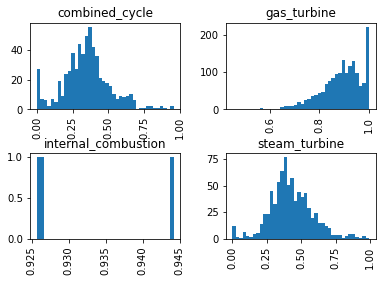

In [52]:
component_aggs['ramp_factor_sum_max'].hist(bins=40, by=component_aggs['simple_EIA_UNIT_TYPE'])

In [75]:
component_aggs.groupby('simple_EIA_UNIT_TYPE')['ramp_factor_sum_max'].describe()

,count,mean,std,min,25%,50%,75%,max
simple_EIA_UNIT_TYPE,,,,,,,,
combined_cycle,606.0,0.347507,0.164115,0.000000,0.254880,0.344024,0.426124,0.956229
gas_turbine,1664.0,0.888563,0.085091,0.448485,0.841945,0.898979,0.953125,1.000000
internal_combustion,3.0,0.932125,0.010431,0.925743,0.926107,0.926471,0.935317,0.944162
steam_turbine,798.0,0.428239,0.159723,0.000000,0.335494,0.408209,0.521556,0.991453


### Make Spot Check Viz

In [53]:
import ramprate.visualize as viz

In [56]:
subset = cems.loc[idx[5,'2019-02-01':'2019-03-01'], 'gross_load_mw']
x = subset.index.get_level_values(1)
y = subset

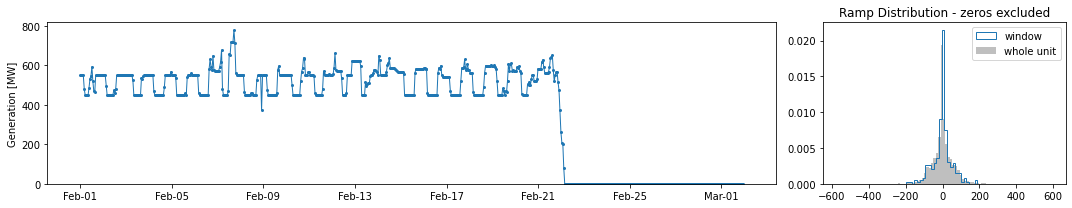

In [57]:
fig, ax = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(15,3))
viz._plot_base_series(x, subset, ax[0])
viz._plot_base_pdf(y.diff().replace(0, np.nan), ax[1], histtype='step', label='window', color=None, alpha=1)
viz._plot_base_pdf(cems.loc[idx[5,:], 'gross_load_mw'].diff().replace(0, np.nan), ax[1], label='whole unit', color='gray')
ax[1].set_title('Ramp Distribution - zeros excluded')
ax[1].legend()
plt.tight_layout()
plt.show()

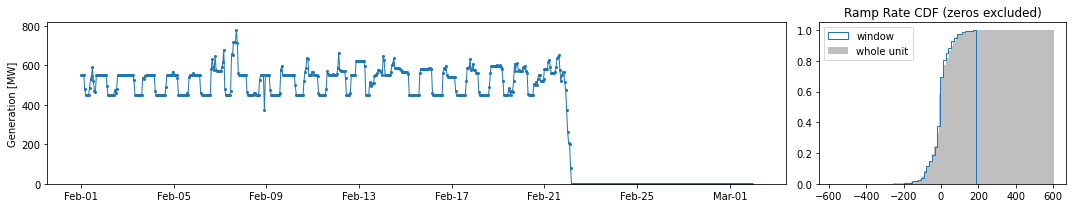

In [58]:
fig, ax = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(15,3))
viz._plot_unit_series_and_ramp_dist(subset, cems.loc[idx[5,:], 'gross_load_mw'], ax[0], ax[1], cdf=True)
plt.tight_layout()
plt.show()

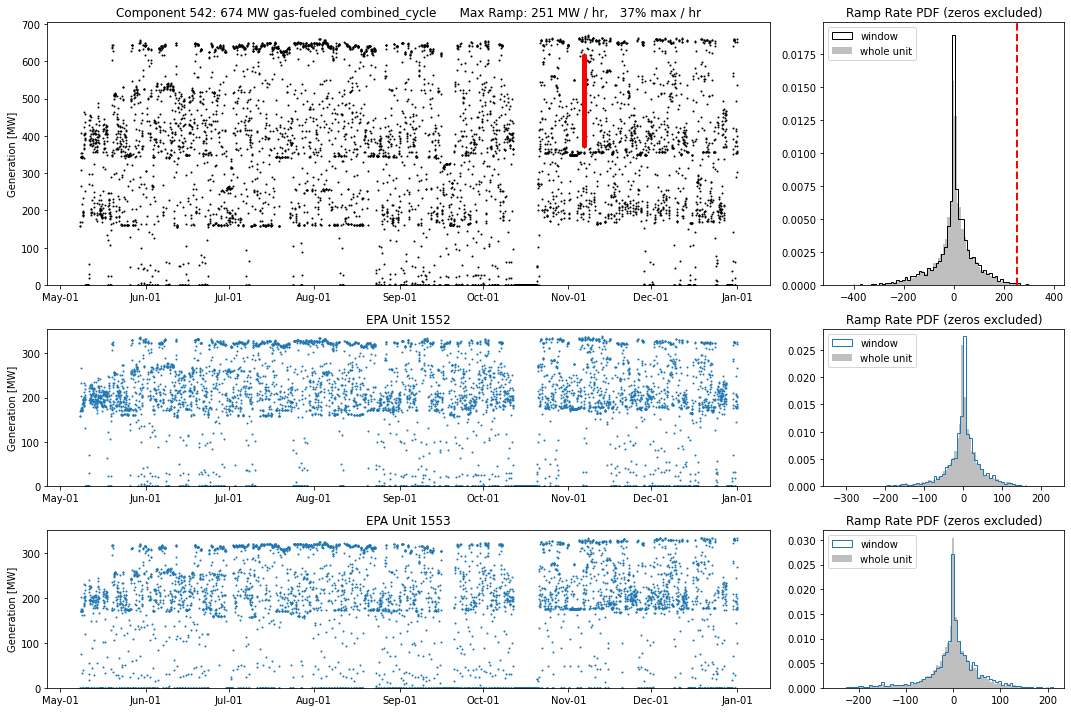

In [59]:
viz.plot_component_max_ramp(542,#component_id=component_aggs.sample().index[0],
                           component_timeseries=component_timeseries,
                           cems=cems,
                           component_aggs=component_aggs,
                           key_map=key_map,
                           window_hours=8760,#10*24,
                           cdf=False,
                           subplot_kwargs=None,
                           )

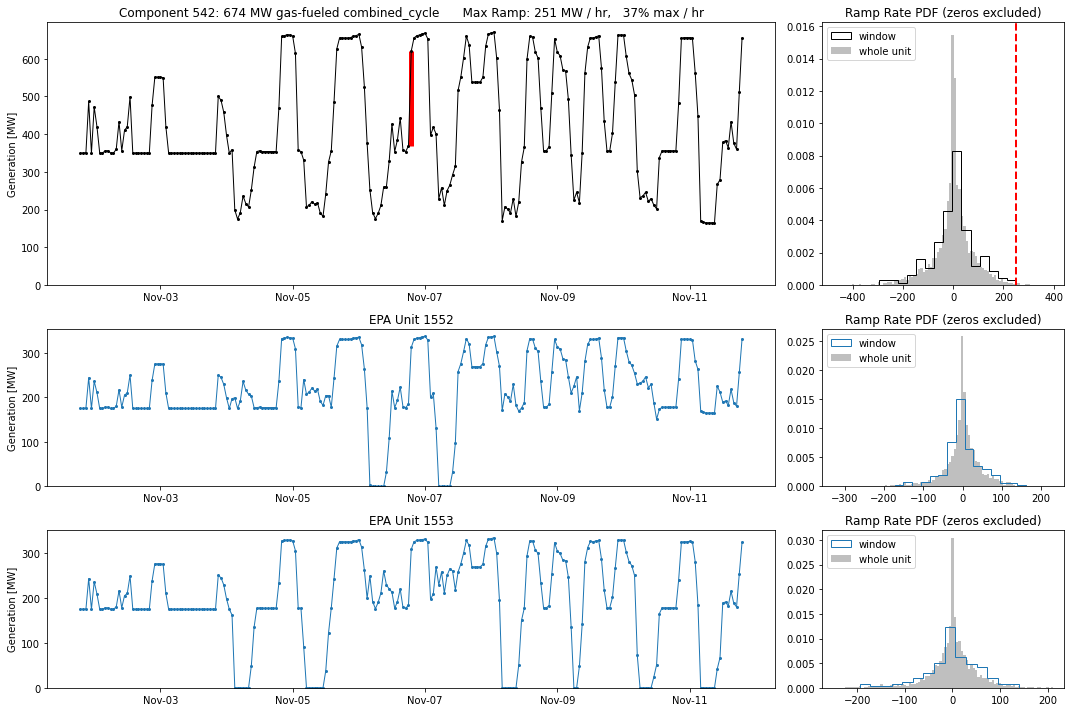

In [60]:
viz.plot_component_max_ramp(542,#component_id=component_aggs.sample().index[0],
                           component_timeseries=component_timeseries,
                           cems=cems,
                           component_aggs=component_aggs,
                           key_map=key_map,
                           window_hours=10*24,
                           cdf=False,
                           subplot_kwargs=None,
                           )

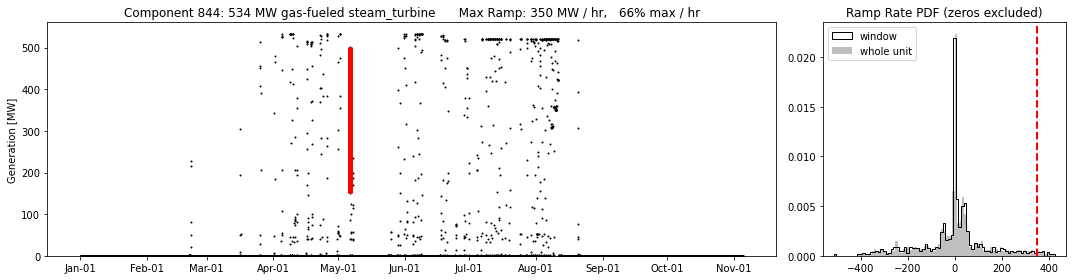

In [61]:
viz.plot_component_max_ramp(844,#component_id=component_aggs.sample().index[0],
                           component_timeseries=component_timeseries,
                           cems=cems,
                           component_aggs=component_aggs,
                           key_map=key_map,
                           window_hours=8760,#10*24,
                           cdf=False,
                           subplot_kwargs=None,
                           )

In [63]:
subset = component_timeseries.loc[idx[1500,'2019-07-08':'2019-08-09'], 'gross_load_mw']
x = subset.index.get_level_values(1)
y = subset

In [67]:
component_aggs.at[1500, 'EIA_UNIT_TYPE']

frozenset({'CA', 'CT'})

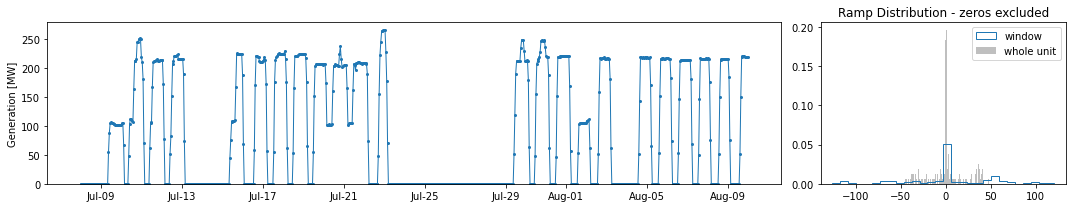

In [64]:
fig, ax = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(15,3))
viz._plot_base_series(x, subset, ax[0])
viz._plot_base_pdf(y.diff().replace(0, np.nan), ax[1], histtype='step', label='window', color=None, alpha=1)
viz._plot_base_pdf(cems.loc[idx[1500,:], 'gross_load_mw'].diff().replace(0, np.nan), ax[1], label='whole unit', color='gray')
ax[1].set_title('Ramp Distribution - zeros excluded')
ax[1].legend()
plt.tight_layout()
plt.show()

## Unrelated Analysis

In [69]:
# number of units
cems.index.levels[0].shape

(4090,)

In [73]:
cems.columns

Index(['plant_id_eia', 'unitid', 'operating_datetime_utc',
       'operating_time_hours', 'gross_load_mw', 'steam_load_1000_lbs',
       'heat_content_mmbtu', 'unit_id_epa', 'hours_from_startup',
       'hours_to_shutdown', 'hours_distance', 'component_id',
       'simple_EIA_UNIT_TYPE', 'exclude_ramp'],
      dtype='object')

In [74]:
cems.groupby('plant_id_eia')['simple_EIA_UNIT_TYPE'].nunique().value_counts()

1    1206
2     135
3      12
Name: simple_EIA_UNIT_TYPE, dtype: int64

In [77]:
# standardize by unit type
normed_ramp_factor = component_aggs.groupby('simple_EIA_UNIT_TYPE')['ramp_factor_sum_max'].transform(lambda x: (x - x.mean()).div(x.std()))

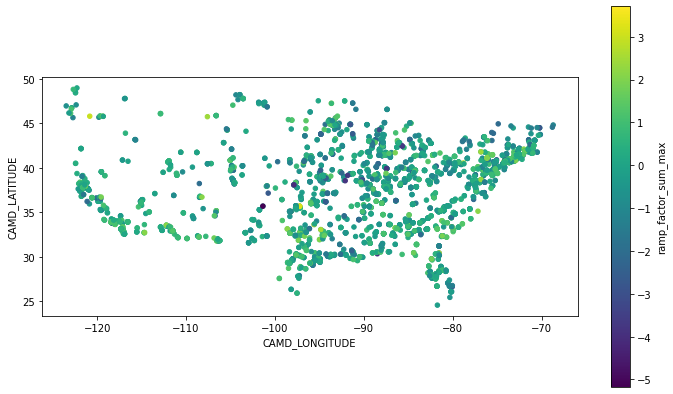

In [85]:
fig, ax = plt.subplots(figsize=(12,7))
(normed_ramp_factor.to_frame()
 .join(key_map.groupby('component_id')[['CAMD_LATITUDE', 'CAMD_LONGITUDE']]
       .first())
 .plot.scatter(x='CAMD_LONGITUDE', y='CAMD_LATITUDE', c='ramp_factor_sum_max', ax=ax, colormap='viridis')
)
ax.set_aspect('equal')

Seems like some of the lower type-normalized ramp factors are in the MISO/SPP area? But this is a very crude method

In [ ]:
assert False

I switched to an inner join so none of the below works. Have to check these things earlier in the process.

Check unmatched CEMS units 

In [68]:
cems['component_id'].isna().groupby('unit_id_epa').all().agg(['sum', 'mean'])

sum     0.0
mean    0.0
Name: component_id, dtype: float64

In [ ]:
# make this easier to read
xwalk['MATCH_TYPE_GEN'] = xwalk['MATCH_TYPE_GEN'].str.replace("3_1_Generator (generators) match on plant and gen IDs  ", '', regex=False)

#### Drop irrelevant CEMS rows
* zero production, neither electrical nor steam, in the data period

In [ ]:
has_prod = cems.groupby(level='unit_id_epa')[['gross_load_mw', 'steam_load_1000_lbs']].sum().gt(0).any(axis=1)

In [ ]:
key_map = key_map[has_prod]
key_map.shape

In [ ]:
key_map.isna().sum()

Some CEMS units failed to join. Are they in the original crosswalk, before dropping unmatched, non-exporting, or non-contemporary units?

In [ ]:
key_map[key_map['CAMD_PLANT_ID'].isna()]

In [ ]:
unmatched = (key_map
             .loc[key_map['CAMD_PLANT_ID'].isna(), ['plant_id_eia', 'unitid', 'unit_id_epa']]
             .merge(raw_crosswalk[['CAMD_PLANT_ID', 'CAMD_UNIT_ID', 'MATCH_TYPE_GEN', 'CAMD_STATUS', "CAMD_STATUS_DATE", "CAMD_RETIRE_YEAR"]].drop_duplicates(),
                    left_on=['plant_id_eia', 'unitid'],
                    right_on=['CAMD_PLANT_ID', 'CAMD_UNIT_ID'],
                    how='left'
                   )
             )

In [ ]:
unmatched['MATCH_TYPE_GEN'].value_counts()

In [ ]:
# drop known exclusions
unmatched = unmatched[unmatched['MATCH_TYPE_GEN'].str.startswith('3_1').fillna(True)]

In [ ]:
unmatched.head(50)

In [ ]:
unmatched['CAMD_RETIRE_YEAR'].value_counts()

In [ ]:
pd.to_datetime(unmatched["CAMD_STATUS_DATE"]).dt.year.value_counts()